# Building an Ocean model

The objective: understand the basics behind a simple global simulation using Oceananigans.jl

## What is Oceananigans.jl?

***Oceananigans.jl*** is an ocean modeling library built in the julia programming language. <br>
Oceananigans is built to be user friendly and flexible and is capable of performing all type of <br>
simulations, from idealized "isotropic" simulation to full realistic oceans! <br>

In this lab you will learn also a bit of ***julia*** (data structures, downloading data, plotting) <br>
mostly in the context of the Oceananigans package, as we go along. You will learn how to set <br>
up and run a simple simulation with Oceananigans.

This includes going through all the Oceananigans building blocks (if time allows it!):
1) Grids (this module)<br>
2) Fields (module 2)<br>
3) Models (module 3)<br>
4) Simulation (module 3)<br>

If you are interested in learning more about julia get in touch on the #julia-helpdesk slack channel



# Part 1: Install a package, download and visualize data

## Packages in julia

As Python, also julia relies on a package system. <br>

To add and load a package it is possible to use the in-built package manager. <br>
For example, if we want to install the package "Downloads" we can add it through `Pkg.add("Downloads")`. <br>
Once it is installed, to use it we can type `using JLD2`

In [3]:
using Pkg
Pkg.add("Downloads")
using Downloads

   Resolving package versions...
  No Changes to `/srv/julia/pkg/environments/v1.7/Project.toml`
  No Changes to `/srv/julia/pkg/environments/v1.7/Manifest.toml`


In the same way we can use Oceananigans with

In [4]:
# If you want to install in your computer you should uncomment
# Pkg.add("Oceananigans")
using Oceananigans

### First step: define the domain

Our ocean is bounded by continents and islands, we can retrieve this information from a _bathymetry_ map. <br>
The term "bathymetry" refers to the ocean's depth relative to sea level. <br>
In the same way a _topographic_ map decribes the elevation of terrain, a _bathymetric_ map illustrates the land that lies underwater. 

The bathymetry will define the domain in which we set up the ocean model. <br>

A dataset containing the bathymetric information can be found online at https://github.com/simone-silvestri/coessing-data/blob/main/bathymetry.jld2.

However, we can download this file within julia leveraging the julia infrastructure.
To download files in julia we can use the `Downloads` package (https://docs.julialang.org/en/v1/stdlib/Downloads/). <br>
This package allows to download data from an online path into your local folder and provides a path to the downloaded data.

In [5]:
using Downloads: download

# We need to define the remote path to the file
onlinepath = "https://github.com/simone-silvestri/coessing-data/raw/main/"

file_path = download(onlinepath * "bathymetry.jld2", "./bathymetry.jld2")

"./bathymetry.jld2"

### JLD2 filetype

The file has been downloaded and is available at the path `"quarter_degree_bathymetry/bathymetry.jld2"`. <br>
Note that the dataset is encoded in a `*.jld2` extension. <br>
This a native julia filetype which can be interacted with using the `JLD2` package

In [6]:
using JLD2
file_bathymetry = jldopen(file_path)

JLDFile /home/jovyan/coessing2022-hub/julia-ocean-model/bathymetry.jld2 (read-only)
 └─🔢 bathymetry

this _JLDFile_ is a `Dictionary`, which in julia represents a collection of datasets that can be accessed using keys _strings_ as keys <br>
(akin to how Dictionaries work in python). <br>
The bathymetry can be accessed with the key "bathymetry"

In [7]:
bathymetry = file_bathymetry["bathymetry"]

# Let's look at the type and size of the variable _bathymetry_
@show size(bathymetry)
@show typeof(bathymetry)

size(bathymetry) = (1440, 600)
typeof(bathymetry) = Matrix{Float64}


Matrix{Float64} (alias for Array{Float64, 2})

The bathymetric map we loaded is a `Matrix` (which is the same as a two-dimensional array `Array`) <br>
with a size of 1440x600. You can think of these numbers as the _resolution_ (number of pixel) of the map. <br>
(this means that we have an HD map!)

### Plotting 2D data

Let's plot the bathymetry to see the shape of the continents <br>
Plotting in julia can be done through the package `CairoMakie` <br>

CairoMakie is quite user friendly to use, the step to plotting are:
- define a figure as `fig = Figure()`. The position in the figure can be accessed as a matrix
- specify an axis in the figure `ax = Axis(fig[1, 1])` (1, 1 stands for position 1, 1 in the figure layout)
- plot something inside the axis (using `ax` as an argument)

For plotting purposes, since we will deal with simulations of the ocean surface <br>
we will use the `heatmap!` function which plots a colorfull contour of a Matrix (nothing but a 2D array) <br>
In a heatmap the `colorrange` keyword specifies the limits of the contour. <br>
The colormap is specified with the `colormap` keyword (choice of different colormaps, :balance, :hot, :viridis, :plasma, etc...)


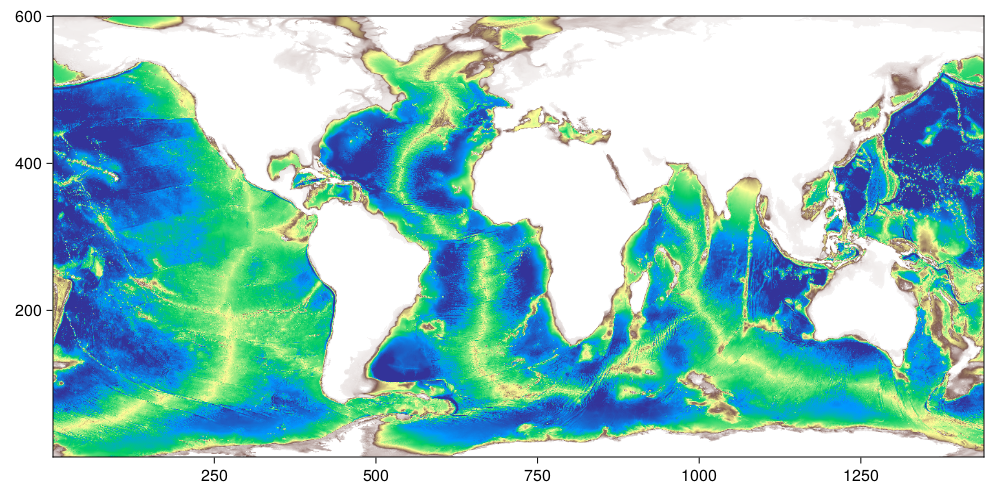

In [8]:
using CairoMakie

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])

heatmap!(ax, bathymetry, colorrange = (-5500, 100), colormap = :terrain)

current_figure()

# Part 2: build a computational Grid

In the ocean the fluid is continuous (there are no empty spaces!), but a computer can only operate on _discrete_ quantities (vectors, arrays, matrices). <br>
To _represent_ a continuous fluid on a computer we need a to _discretize_ our geometry into "computational cells", which taken all together define a ***grid***.

Grids are the backbone of all fluid flow simulations: constructing an adequate grid goes a long way in ensuring a good quality model.

Oceananigans allows to construct two types of grids: 
- a `RectilinearGrid` for problems defined in a rectangular space
- a `LatitudeLongitudeGrid` for problems defined on a sphere

We want to discretize the ocean, so we need a sphere!
Let's choose the number of points in the latitude and longitude direction (`Nlat` and `Nlon`) and construct our grid

In [9]:
Nlon = 1440
Nlat = 600

initial_grid = LatitudeLongitudeGrid(size = (Nlon, Nlat, 1), longitude = (-180, 180), latitude = (-75, 75), z = (0, 1))

1440×600×1 LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo and with precomputed metrics
├── longitude: Periodic λ ∈ [-180.0, 180.0) regularly spaced with Δλ=0.25
├── latitude:  Bounded  φ ∈ [-75.0, 75.0]   regularly spaced with Δφ=0.25
└── z:         Bounded  z ∈ [0.0, 1.0]      regularly spaced with Δz=1.0

Now we have to discretize the domain we have (the bathymetric map) into our grid. <br>
I have already defined some convenience functions to do that in the file "usefull_functions.jl"

In julia we can load source files `(*.jl)` through the function `include`. <br>
This will load all the functions defined in the source file. <br>

In [10]:
include("utils/useful_functions.jl")
grid = immersed_boundary_grid(initial_grid, bathymetry);

The `visualize_cartesian_grid` function is defined in "useful_functions.jl". <br> 
It uses the `CairoMakie` package to visualize a wireframe of the grid and a 
heatmap of the continental mask.

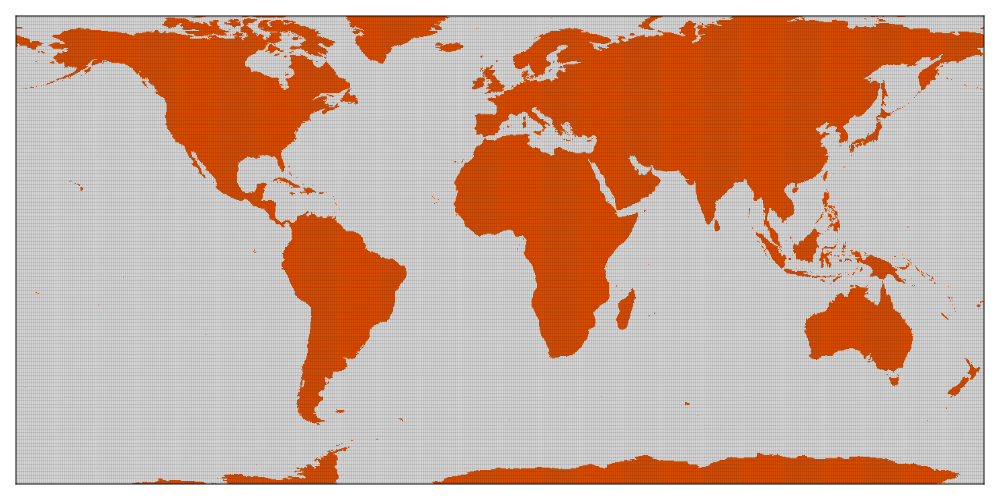

In [11]:
fig = visualize_cartesian_grid(grid)
current_figure()

You can again think at the number of cells in a grid as the number of pixel in an image; more pixels in an image allow you to see more details. <br>
The same happens in an ocean simulation, the more cells (pixel) in your grid, <br>
the more detailed physics you can resolve.

## Exercise: change the resolution of the grid

try changing the number of points in the longitudinal (`Nlat`) and the latitudinal (`Nlon`) direction, <br>
and see for yourself how the representation of the continents change

#### Note!
the bathymetry data is (1440 x 600) so the maximum resolution allowable is `Nx = 1440`, `Ny = 600`

In [12]:
## Write the new grid here
## look at the examples above:

# - define Nlon and Nlat
# - build an initial_grid
# - build the grid with the immersed_boundary_grid function
# - visualize with the visualize_figure function
# - display the figure with current_figure()

# Part 3: download and interact with a velocity field

### Download velocity datasets

To download the (precomputed) velocity datasets we, once again, use the `Downloads` package.

The file containing the velocity datasets can be found online at https://github.com/simone-silvestri/coessing-data/raw/main/prescribed_mean_fields.jld2

In [13]:
onlinepath = "https://github.com/simone-silvestri/coessing-data/raw/main/"

file_path = download(onlinepath * "prescribed_mean_fields.jld2", "./prescribed_mean_fields.jld2")

file_velocities = jldopen(file_path)

JLDFile /home/jovyan/coessing2022-hub/julia-ocean-model/prescribed_mean_fields.jld2 (read-only)
 ├─🔢 um
 └─🔢 vm

This file is again a Dictionary containing two datasets:
- um
- vm 

Here `um` is the _zonal_ surface velocity (the surface velocity in the West-East direction) <br>
and `vm` is the _meridional_ surface velocity (the surface velocity in the South-North direction). <br>
 
these datasets contain the ***average*** of the velocities over a time span of 10 years. <br>
Let's assign these datasets to two variables and look at their structure

In [14]:
const Um = file_velocities["um"]
const Vm = file_velocities["vm"]

@show typeof(Um);
@show size(Um);
@show typeof(Vm)
@show size(Vm);

typeof(Um) = Array{Float64, 3}
size(Um) = (1440, 600, 1)
typeof(Vm) = Array{Float64, 3}
size(Vm) = (1440, 601, 1)


Note that they are both ***3D*** arrays! Oceananigans always works with three dimensional data for simplicity, <br>
a two dimensional dataset (as in this case) is a 3D array with ***one*** point in the unused direction

let's plot the zonal velocity with `CairoMakie`. 

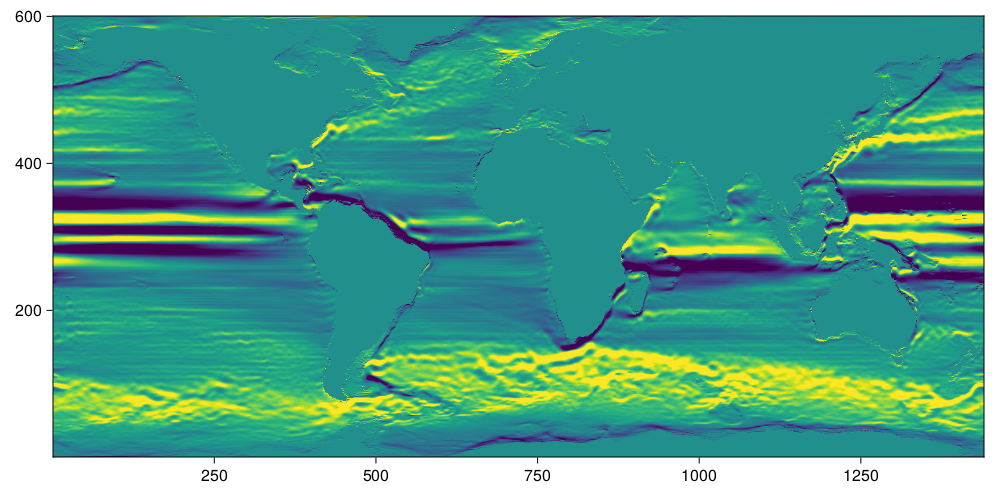

In [15]:
# Mean zonal velocity
fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, Um[:, :, 1], colorrange = (-0.2, 0.2))
current_figure()

At the moment the velocity has zero values where the continents are supposed to be. <br>
To better visualize the datasets, let's create a "continent mask" to overlay to our velocity. <br>
We want to have a mask that has all the elements for which `bathymetry > 0` (over sea level) equal to `NaN`s (these will be our continents) <br> and all elements for which `bathymetry < 0` (the ocean) equal to `0`. 

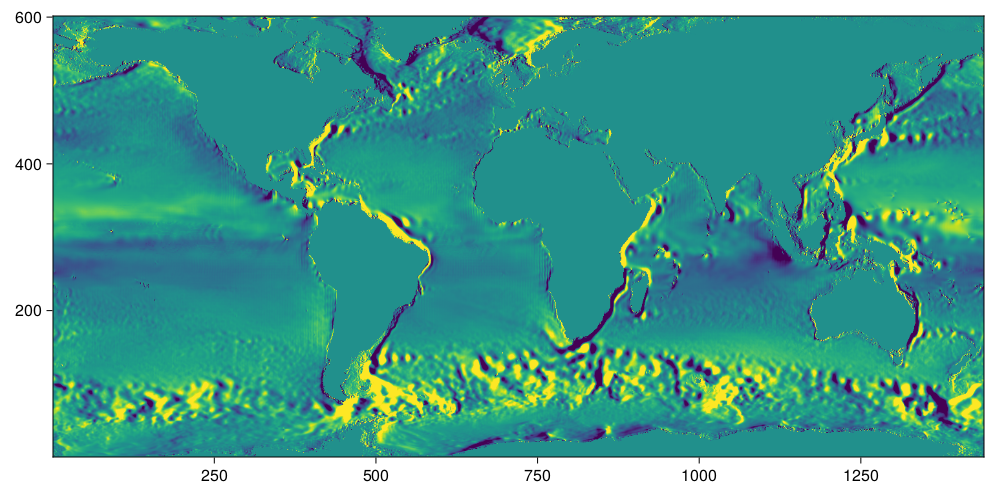

In [16]:
# Mean meridional velocity
v = Vm[:, :, 1]

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, v, colorrange = (-0.1, 0.1))
current_figure()

### Second building block: Oceananigans's Fields!

Oceananigans represents variables connected to a particular grid with a `Field` type. <br> 
Fields are essentially containers which include the grid, the data allocated on the grid (the previously seen 3D arrays), <br>
as well as the eventual boundary conditions.

We can define empty fields (i.e., empty containers) for our velocities and fill them with the velocity data we loaded

In [17]:
U = XFaceField(grid)
V = YFaceField(grid)

set_velocity_from_array!(U, Um)
set_velocity_from_array!(V, Vm)

1440×601×1 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 1446×607×7 OffsetArray(::Array{Float64, 3}, -2:1443, -2:604, -2:4) with eltype Float64 with indices -2:1443×-2:604×-2:4
    └── max=2.11723, min=-1.68651, mean=0.00532223

### Combining fields

Fields are handy because they can be combined through expressions. <br>
as an example, let's calculate the mean kinetic energy at the surface defined as

$$K = 0.5 * (U^2 + V^2)$$

In [18]:
K = Field(0.5 * (U^2 + V^2))
compute!(K)

1440×600×1 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: ZeroFlux, north: ZeroFlux, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
├── operand: BinaryOperation at (Face, Center, Center)
├── status: time=0.0
└── data: 1446×606×7 OffsetArray(::Array{Float64, 3}, -2:1443, -2:603, -2:4) with eltype Float64 with indices -2:1443×-2:603×-2:4
    └── max=1.98573, min=0.0, mean=0.00737816

Now let's see how kinetic energy of the surface looks like. <br>
We can plot is trough `CairoMakie` as we have done before, but we have to extract data from the field to plot it! <br>

To access the data associated with an Oceananigans field we can use the function `interior`

typeof(k) = SubArray{Float64, 3, Array{Float64, 3}, Tuple{UnitRange{Int64}, UnitRange{Int64}, UnitRange{Int64}}, false}


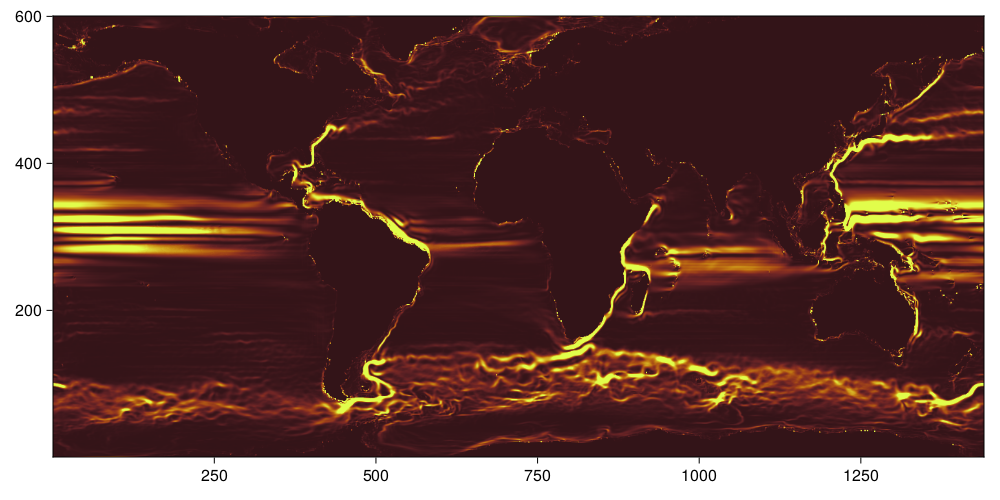

In [19]:
k = interior(K)

# The data associated with a field is always three dimensional!
@show typeof(k);

fig = Figure(resolution = (1000, 500))
ax = Axis(fig[1, 1])
heatmap!(ax, k[:, :, 1], colorrange = (0, 0.05), colormap = :solar)

current_figure()

### Computing derivatives

In the same way we can compute derivatives. <br>
For example, let's calculate and plot the latitudinal derivative of the zonal velocity
$$S = \frac{\partial U}{\partial x}$$

Note that julia supports Unicode. <br>
The differentiation operator in Oceananigans is defined with the $\partial$ symbol. <br>
To write it out in julia, type `\partial` and then press the TAB key

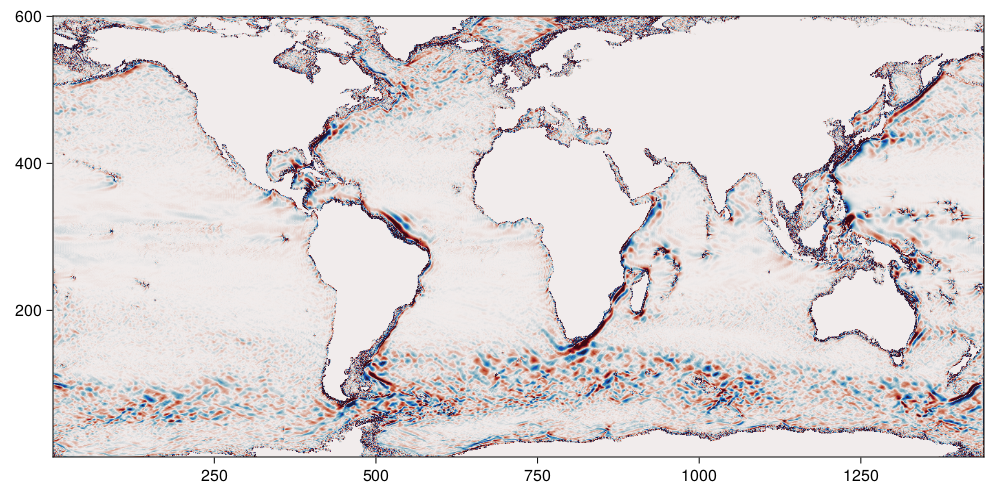

In [20]:
S = Field(∂x(U))
compute!(S)

s = interior(S)

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, s[:, :, 1], colorrange = (-2e-6, 2e-6), colormap = :balance)

current_figure()

## Exercise: interact with the velocity field

define and plot a new field as a function of `U` and `V`

#### Remember!
- the derivative operator in Oceananigans is constructed with \partial+TAB (followed by the direction: x or y)
- heatmap plots 2D AbstractArrays (SubArrays are AbstractArrays)
- the data of a field is retrieved by the `interior` function
- Fields are _always_ three dimensional

#### Tips
- You can use the `typeof` and `size` function to confirm that the variable you want to plot is a 2D array (or matrix)
- Follow the example above for plotting and use `colorrange = (extrema(field))` and `colormap = :blues`
- don't forget to display the figure with `current_figure()` at the end of the cell!

In [21]:
## Write the new field here
## look at the examples above:

# - define the operation you want to calculate (ex: U + 0.5 * V)
# - wrap it around a Field constructor (field = Field(expression))
# - compute the field with compute!(field)
# - extract the data with data = interior(field)
# - display the data with heatmap!
